In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras\from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, roc_curve
import pickle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/drive


In [3]:
#Import Data
gene_df = pd.read_csv("/content/drive/Shareddrives/5461 Project/data/Challenge_GIN_release_profile_17804library_181query.txt",sep='\t')
challengeA_df = pd.read_csv("/content/drive/Shareddrives/5461 Project/data/ChallengeA_release_GO_BP_20_500_17804library_1106terms.txt",sep='\t')


In [4]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
EPOCHS = 50
BATCH_SIZE = 2048
def make_model(metrics=METRICS, output_bias=None, input_size=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          1100, activation='relu',
          input_shape=(input_size,)),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(
          1100, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(
          1100, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1106,activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss="binary_crossentropy",
      metrics=metrics)

  return model

def evaluate_model(X, y, epochs):
  results = []
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=8, n_repeats=2, random_state=1)
  # enumerate folds
  for train_ix, test_ix in cv.split(X):
  # prepare data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    bias = []
    for i in range(y_train.shape[1]):
      neg, pos = np.bincount(y_train.iloc[:, i])
      total = neg + pos
      bias.append(np.log(pos/neg))
    # define model
    model = make_model(output_bias=bias, input_size = X.shape[1])

    # fit model
    model.fit(X_train, y_train, batch_size=70,epochs = epochs, validation_data=(X_test,y_test))  

    # predict test labels
    y_pred = model.predict(X_test)
    scores = np.zeros(y.shape[1])
    y_pred = y_pred.transpose()
    # calculate auroc score for each go term
    for ix, col in enumerate(y.columns):
      if sum(y_test.loc[:, col]) >0:
        scores[ix] = roc_auc_score(y_test.loc[:, col], y_pred[ix])
    results.append(np.mean(scores))
  return results

# y_pred must be transposed
def convert_prediction_probability(y_true, y_pred):

  # Determine best threshold for each go term and binarize predictions
  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  # Calculate G means score at each threshold
  gmeans = np.sqrt(tpr * (1-fpr))
  ix = np.argmax(gmeans)
  go_thresh = threshold[ix]
  # Binarize predictions from probabilities
  predictions = y_pred >= go_thresh
  predictions = predictions.astype(int)
  return predictions

Epoch 1/5
147/147 [==============================] - 5s 12ms/step - loss: 0.0267 - tp: 61.0000 - fp: 36.0000 - tn: 14099005.0000 - fn: 62122.0000 - accuracy: 0.9956 - precision: 0.6289 - recall: 9.8098e-04 - auc: 0.6832 - prc: 0.0151 - val_loss: 0.0269 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2819949.0000 - val_fn: 12517.0000 - val_accuracy: 0.9956 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6779 - val_prc: 0.0129
Epoch 2/5
147/147 [==============================] - 1s 7ms/step - loss: 0.0265 - tp: 5.0000 - fp: 30.0000 - tn: 11279062.0000 - fn: 49661.0000 - accuracy: 0.9956 - precision: 0.1429 - recall: 1.0067e-04 - auc: 0.6852 - prc: 0.0142 - val_loss: 0.0267 - val_tp: 16.0000 - val_fp: 13.0000 - val_tn: 2819936.0000 - val_fn: 12501.0000 - val_accuracy: 0.9956 - val_precision: 0.5517 - val_recall: 0.0013 - val_auc: 0.6850 - val_prc: 0.0170
Epoch 3/5
147/147 [==============================] - 1s 7ms/step - loss: 0.0263 - tp: 76.0000 - fp: 91.0000 - tn: 

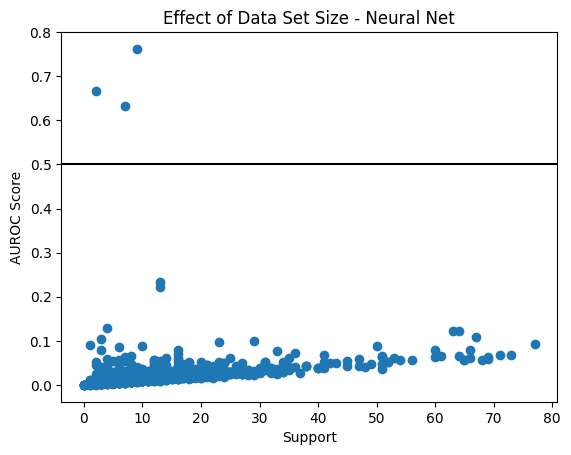

In [11]:
# Seperate test data
X = gene_df.iloc[5000:,1:]
X = X.set_index(pd.Index(range(0,X.shape[0])))
X_eval = gene_df.iloc[:5000,1:]
y = challengeA_df.iloc[5000:, 1:]
y = y.set_index(pd.Index(range(0,y.shape[0])))
y = y.replace(-1, 0)

# Seperate data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)
bias = []
# Calculate output node bias for each go term
for i in range(y_train.shape[1]):
  neg, pos = np.bincount(y_train.iloc[:, i])
  total = neg + pos
  bias.append(np.log(pos/neg))

# Make and fit model to all data
model = make_model(output_bias=bias, input_size=x_train.shape[1])
model.fit(x_train, y_train, batch_size=70,epochs = 5, validation_data=(x_test, y_test)) 

# Make predictions and calculate auroc score vs number of positive classes
y_pred = model.predict(x_test)
y_pred = y_pred.transpose()
scores = []
support = []
for i, col in enumerate(y.columns):
  if sum(y_test.iloc[:,i]) > 0:
    y_pred_binary = convert_prediction_probability(y_test.iloc[:, i], y_pred[i])
    score = f1_score(y_test.iloc[:, i], y_pred_binary, average = "binary")
    neg, pos = np.bincount(y_test.iloc[:, i])
    scores.append(score)
    support.append(pos)
  else:
    scores.append(0)
    support.append(0)

plt.scatter(support, scores)
plt.axhline(y=0.5, color='black')
plt.title('Effect of Data Set Size - Neural Net')
plt.xlabel('Support')
plt.ylabel('AUROC Score')
  
f1_go_terms = np.array(scores)
print("Mean F1 Score:", np.mean(f1_go_terms))
ranked_f1_go_terms = np.argsort(f1_go_terms)
for i in ranked_f1_go_terms:
  print(scores[i], y.columns[i])

# for i, column in enumerate(y.columns):
#     try:
#         auc = roc_auc_score(y_test.iloc[:,i], y_pred[i])
#         roc_score.append(auc)
#     except:
#         roc_score.append(0)
# plt.hist(roc_score, bins=100)
# plt.title('Neural Net ROC AUC Scores')
# plt.axvline(x=0.5, color='black')
# plt.ylim(0,100)
# plt.xlabel('AUC')
# plt.ylabel('Count')
# print(np.mean(np.array(roc_score)))



In [ ]:
y_test

,GO:0000027,GO:0000045,GO:0000070,GO:0000077,GO:0000079,GO:0000082,GO:0000083,GO:0000086,GO:0000132,GO:0000184,...,GO:2000352,GO:2000378,GO:2000379,GO:2000463,GO:2001235,GO:2001237,GO:2001238,GO:2001240,GO:2001243,GO:2001244
4224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Predictions for submittion
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)
bias = []
# Calculate output node bias for each go term
for i in range(y_train.shape[1]):
  neg, pos = np.bincount(y.iloc[:, i])
  total = neg + pos
  bias.append(np.log(pos/neg))

# Make and fit model to all data
model = make_model(output_bias=bias)
model.fit(X, y, batch_size=70,epochs = 6)  
# Predictions for the train set
y_train_pred = model.predict(X)
y_train_pred = y_train_pred.transpose()
# Predictions for the Evaluation set
y_pred_eval = model.predict(X_eval)
y_pred_eval = y_pred_eval.transpose()
eval_df = pd.DataFrame(columns = y.columns)
eval_df.insert(0, "id", gene_df.iloc[:5000,0])
total = 0
# Determine best threshold for each go term and binarize predictions
for i, col in enumerate(y.columns):
    # Calculate roc curve
    fpr, tpr, threshold = roc_curve(y.iloc[:,i], y_train_pred[i])
    # Calculate G means score at each threshold and pick threshold with best score
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    go_thresh = threshold[ix]
    # Binarize predictions from probabilities 
    predictions = y_pred_eval[i] >= go_thresh
    predictions = predictions.astype(int)
    eval_df[col] = predictions
    total += sum(predictions)


Epoch 1/6
183/183 [==============================] - 3s 7ms/step - loss: 0.0267 - tp: 4739.0000 - fp: 2337.0000 - tn: 28195748.0000 - fn: 119627.0000 - accuracy: 0.9957 - precision: 0.6697 - recall: 0.0381 - auc: 0.7802 - prc: 0.0959
Epoch 2/6
183/183 [==============================] - 1s 6ms/step - loss: 0.0265 - tp: 38.0000 - fp: 90.0000 - tn: 14098951.0000 - fn: 62145.0000 - accuracy: 0.9956 - precision: 0.2969 - recall: 6.1110e-04 - auc: 0.6869 - prc: 0.0153
Epoch 3/6
183/183 [==============================] - 1s 6ms/step - loss: 0.0262 - tp: 91.0000 - fp: 165.0000 - tn: 14098876.0000 - fn: 62092.0000 - accuracy: 0.9956 - precision: 0.3555 - recall: 0.0015 - auc: 0.6969 - prc: 0.0196
Epoch 4/6
183/183 [==============================] - 1s 7ms/step - loss: 0.0259 - tp: 400.0000 - fp: 417.0000 - tn: 14098624.0000 - fn: 61783.0000 - accuracy: 0.9956 - precision: 0.4896 - recall: 0.0064 - auc: 0.7066 - prc: 0.0286
Epoch 5/6
183/183 [==============================] - 2s 10ms/step - loss

In [ ]:
kaggle = pd.read_csv("/content/drive/Shareddrives/5461 Project/data/kaggle.csv")
kaggle_submission = eval_df[kaggle.columns]
kaggle_submission.to_csv("/content/drive/Shareddrives/5461 Project/data/Neural_Net_kaggle_test.csv", index = False)


In [ ]:
submission_df = pd.DataFrame(columns = y.columns)
submission_df.insert(0, "id", gene_df.iloc[:5000,0])
y_pred_eval.shape
for i, col in enumerate(y.columns):
  submission_df[col] = y_pred_eval[i]
submission_df.to_csv("/content/drive/Shareddrives/5461 Project/data/Neural_Net_Predictions_Submission_highest.csv", index = False)


[6.0800847e-04 6.0593936e-04 5.9638023e-05 ... 4.3679573e-04 6.0271902e-04
 1.7026694e-04]
[0.00204774 0.00429231 0.01273321 ... 0.0023368  0.00328326 0.00189385]
[0.00079028 0.00103219 0.0004485  ... 0.00080652 0.00090634 0.00019293]
[1.9591546e-03 6.7971007e-04 3.6962552e-05 ... 5.5821304e-04 8.6182734e-04
 1.6921799e-04]
[0.00314321 0.00212204 0.00065136 ... 0.00159486 0.0019366  0.00067361]
[0.00414677 0.00327731 0.00242945 ... 0.00219549 0.00263005 0.0009998 ]
[0.00202492 0.0012264  0.00050655 ... 0.00129175 0.00134003 0.00066068]
[0.00604283 0.00523879 0.00272701 ... 0.00516916 0.00504407 0.00241228]
[0.00147857 0.00110392 0.00046444 ... 0.00085511 0.0011448  0.00030108]
[0.00485184 0.00395251 0.00118794 ... 0.00146902 0.00359323 0.00053887]
[0.00115554 0.00215334 0.00046382 ... 0.00243537 0.0020744  0.00045739]
[0.00336586 0.00405456 0.00038688 ... 0.00670969 0.00400871 0.00137377]
[0.00162289 0.00094717 0.00019417 ... 0.00093655 0.00107499 0.00064786]
[0.00985796 0.01344984 0.0